Import Libraries

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif  # Information Gain
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


Path Dataset

In [2]:
DATASET_PATH = "dataset/augmented_audio"
LABELS = ["buka", "tutup"]  # multi-label classification


Ekstraksi 156 Fitur Audio

In [5]:
def extract_features_156(file_path):
    y, sr = librosa.load(file_path, sr=None)

    features = []

    # ====== TEMPORAL / ENERGY (4 fitur) ======
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    rms = librosa.feature.rms(y=y)[0]
    features += [np.mean(zcr), np.std(zcr)]
    features += [np.mean(rms), np.std(rms)]

    # ====== SPECTRAL BASIC (8 fitur) ======
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    roll = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    flat = librosa.feature.spectral_flatness(y=y)[0]

    features += [np.mean(cent), np.std(cent)]
    features += [np.mean(roll), np.std(roll)]
    features += [np.mean(bw), np.std(bw)]
    features += [np.mean(flat), np.std(flat)]

    # ====== SPECTRAL CONTRAST (14 fitur) ======
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    for c in contrast:
        features += [np.mean(c), np.std(c)]  # 7 bands × mean & std = 14 fitur total

    # ====== MFCC (80 fitur) ======
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    for coef in mfcc:
        features += [np.mean(coef), np.std(coef)]

    # ====== MEL SPECTROGRAM (40 fitur = 20 bands × mean + std) ======
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=20)
    for m in mel:
        features += [np.mean(m), np.std(m)]

    # ====== CHROMA (12 fitur = 6 chroma × mean + std) ======
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=6)
    for c in chroma:
        features += [np.mean(c), np.std(c)]

    # ====== TEMPO (1 fitur) ======
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features.append(tempo)

    return features


Load Dataset & Ekstraksi Fitur

In [7]:
data = []
labels = []

for label in LABELS:
    folder = os.path.join(DATASET_PATH, label)

    for file in tqdm(os.listdir(folder), desc=f"Extracting {label}"):
        path = os.path.join(folder, file)
        feats = extract_features_156(path)
        data.append(feats)
        labels.append(label)

df = pd.DataFrame(data)
df["label"] = labels

df.to_csv("audio_features.csv", index=False)
print(df.shape)
print("Jumlah fitur per audio:", len(df.columns)-1)



Extracting tutup: 100%|██████████| 100/100 [00:09<00:00, 10.48it/s]


(200, 160)
Jumlah fitur per audio: 159


EDA - Cek struktur DataFrame & Missing Values

In [9]:
print("Jumlah baris & kolom:", df.shape)
print("\n5 data pertama:")
display(df.head())

print("\nInfo dataset:")
print(df.info())

print("\nJumlah missing values:")
print(df.isnull().sum())


Jumlah baris & kolom: (200, 160)

5 data pertama:


,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,label
0,0.459906,0.073448,0.070864,0.030837,11648.770057,850.690046,20282.812500,508.539744,7065.000240,221.994486,...,0.863444,0.106164,0.874079,0.114302,0.878574,0.119374,0.881024,0.118533,[73.05194805194805],buka
1,0.057997,0.034655,0.008515,0.014614,2699.508640,1311.634540,4694.180254,2288.990149,3218.969346,1308.163959,...,0.674389,0.284803,0.644628,0.276367,0.703214,0.245367,0.743049,0.246920,[122.28260869565217],buka
2,0.021747,0.017319,0.005095,0.007642,1772.291792,903.973625,3679.965415,1884.874123,2882.931136,1067.340527,...,0.693850,0.197383,0.848923,0.190073,0.805589,0.236101,0.676471,0.276561,[63.92045454545455],buka
3,0.028392,0.029178,0.004412,0.006877,2299.709707,1389.429776,4685.479526,2941.262268,3522.686429,1414.374217,...,0.794792,0.186507,0.798117,0.234085,0.776737,0.279372,0.733027,0.234690,[86.53846153846153],buka
4,0.053191,0.032885,0.004496,0.007919,2618.429488,1173.078124,4920.371462,2084.468678,3287.316572,1159.393901,...,0.705483,0.244888,0.747431,0.262200,0.663892,0.277499,0.536724,0.279245,[140.625],buka



Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 160 entries, 0 to label
dtypes: float32(136), float64(22), object(2)
memory usage: 143.9+ KB
None

Jumlah missing values:
0        0
1        0
2        0
3        0
4        0
        ..
155      0
156      0
157      0
158      0
label    0
Length: 160, dtype: int64


Visualisasi distribusi label (buka / tutup)

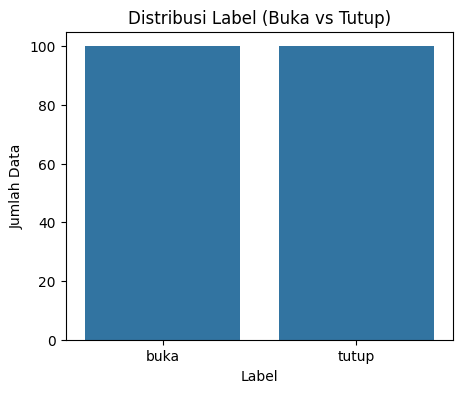

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.countplot(x=df["label"])
plt.title("Distribusi Label (Buka vs Tutup)")
plt.xlabel("Label")
plt.ylabel("Jumlah Data")
plt.show()


Deteksi Outlier (Menggunakan Boxplot)

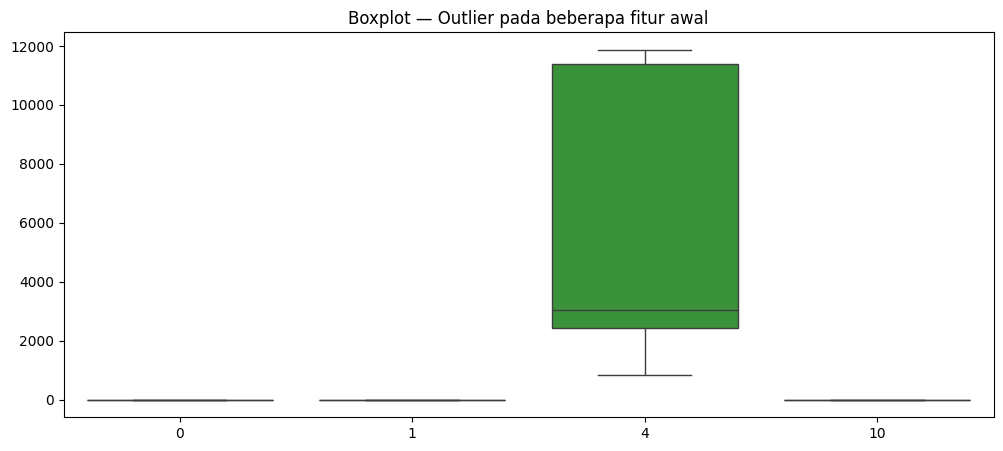

In [11]:
eda_cols = [0, 1, 4, 10]  # indeks fitur awal (ZCR_mean, ZCR_std, RMS_mean, RMS_std)

plt.figure(figsize=(12,5))
sns.boxplot(data=df.iloc[:, eda_cols])
plt.title("Boxplot — Outlier pada beberapa fitur awal")
plt.show()


Korelasi Antar Fitur (Heatmap)

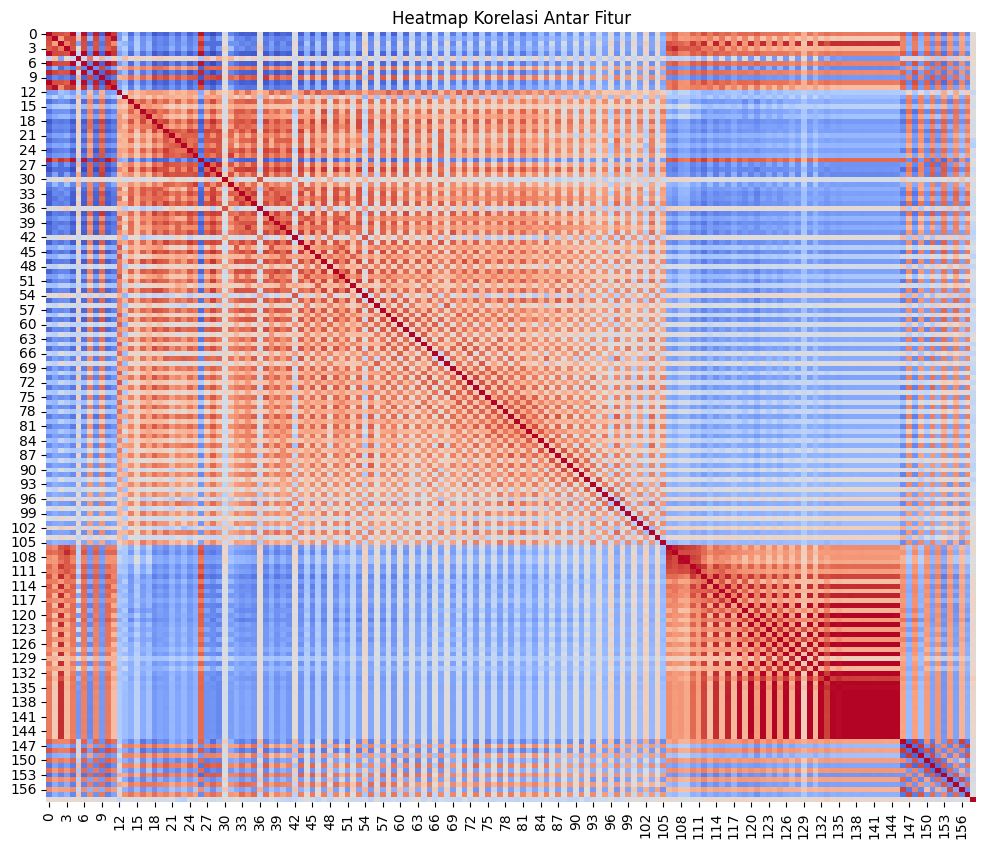

In [12]:
plt.figure(figsize=(12,10))
corr = df.drop("label", axis=1).corr()
sns.heatmap(corr, cmap="coolwarm", cbar=False)
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()


Distribusi fitur untuk setiap label (Violin Plot)

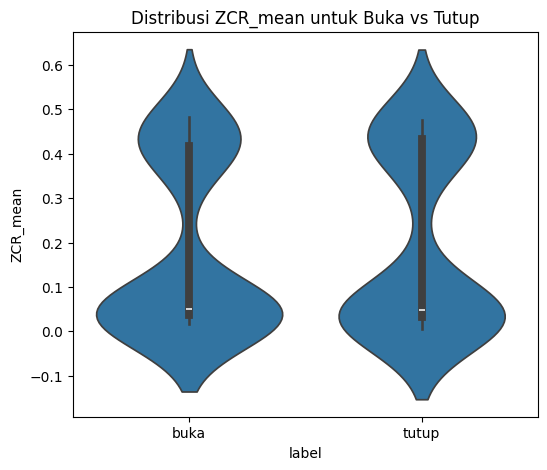

In [13]:
df_eda = df.copy()
df_eda["ZCR_mean"] = df.iloc[:, 0]  # fitur pertama ZCR mean

plt.figure(figsize=(6,5))
sns.violinplot(x="label", y="ZCR_mean", data=df_eda)
plt.title("Distribusi ZCR_mean untuk Buka vs Tutup")
plt.show()


Preprocessing: Encoding Label + Split Dataset

In [14]:
X = df.drop("label", axis=1)
y = df["label"]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (160, 159) Test: (40, 159)


Stanadardisasi Data

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Model 1 (SVM dengan semua fitur)

In [16]:
svm_full = SVC(kernel="rbf")
svm_full.fit(X_train_scaled, y_train)

y_pred_full = svm_full.predict(X_test_scaled)

print("=== AKURASI SEMUA FITUR ===")
print("Accuracy:", accuracy_score(y_test, y_pred_full))
print(classification_report(y_test, y_pred_full))


=== AKURASI SEMUA FITUR ===
Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



Seleksi Fitur (Information Gain)

In [17]:
info_gain = mutual_info_classif(X_train_scaled, y_train)

importances = pd.Series(info_gain)
selected_index = importances.sort_values(ascending=False).head(50).index

X_train_sel = X_train_scaled[:, selected_index]
X_test_sel = X_test_scaled[:, selected_index]


In [18]:
svm_ig = SVC(kernel="rbf")
svm_ig.fit(X_train_sel, y_train)

y_pred_sel = svm_ig.predict(X_test_sel)

print("=== AKURASI SETELAH SELEKSI FITUR (IG) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_sel))
print(classification_report(y_test, y_pred_sel))


=== AKURASI SETELAH SELEKSI FITUR (IG) ===
Accuracy: 0.9
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.94      0.85      0.89        20

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40

